# WARNING - Don't need to run any of this anymore - this is the original data munging

In [ ]:
import pandas as pd
import sqlite3

# Importing smaller movie_metedata via csv
# movies = pd.read_csv("movie_metadata.csv")
# movies.head()

# read movie data table from db into dataframe
con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movies = pd.read_sql(sql, con)
# set max display to see all available columns
pd.set_option('display.max_columns', 500)
movies.head()
# Checking for duplicates...
movies['imdb_num_code'].value_counts()

In [ ]:
# Print list of columns in smaller movies dataframe, in alphabetical order
for col in movies.columns.sort_values().values:
    print (col)

In [ ]:
movies_large = pd.read_csv('movies_metadata.csv')
movies_large = movies_large.set_index('imdb_id')
movies_large.head()

In [ ]:
for col in movies_large.columns.sort_values().values:
    print (col)

In [ ]:
movies.describe()
# Originally was ~4,900-5,100 records before re-pulling the data on 6/23 @ 8:21 pm...
# Believe it is because Seth dropped all N/A values
# New record count is not 3,738

In [ ]:
movies_large.describe()

In [ ]:
# Converting popularity from type 'object' to type 'numeric' (float)
movies['popularity'] = pd.to_numeric(movies['popularity'])
# Checking counts and types...nothing has changed.  
# Actually, there appears to be two more records now.  Why?
movies.describe()

In [ ]:
# Create new dataframe with just the production companies and genres from large dataset
movies_large_pc = movies_large[["production_companies","genres"]]
movies_large_pc.head()

In [ ]:
# Counting the number of production companies and genres per movie
movies_large_pc['production_companies_count'] = movies_large_pc['production_companies'].str.count('id')
movies_large_pc['genres_count'] = movies_large_pc['genres'].str.count('name')
movies_large_pc.head()

In [ ]:
# Add new columns to the existing movies table in sqllite db

# Columns straight from large dataset
movies = movies.merge(movies_large_pc[['production_companies_count','genres_count']], left_on="imdb_num_code", right_index=True, how="inner")
# Calculated columns based on occurrences of strings in certain columns
movies = movies.merge(movies_large[['popularity','vote_count','vote_average']], left_on="imdb_num_code", right_index=True, how="inner")
movies

# Definitions of new fields:

# Popularity: (Undetermined at this point on how this is calculated) - appears to be 0 to 100 rating scale.
# Vote Count: Number of users that voted for the movie on the TMDB website.
# Vote Average: Average score from the aforementioned votes.  
# Production Companies Count: Number of production companies that were a part of developing the movie.
# Genres Count: Number of genre classifications assigned to each movie.

# Website for large dataset:
# https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv



In [ ]:
# Code to drop dups if the above cell is written multiple times
# movies = movies.drop(['popularity_x','vote_count_x','vote_average_x','production_companies_count_x',
#                     'genres_count_x','production_companies_count_y','genres_count_y','popularity_y',
#                     'vote_count_y','vote_average_y'],axis=1)


In [ ]:
# Seem to be duplicate records now...
movies['imdb_num_code'].value_counts()

# Also, why is there 128 duplicate records for tt0157472?

In [ ]:
# Remove duplicates
# removeDups2_movies = movies.drop_duplicates(subset ="imdb_num_code", 
#                      keep = 'first', inplace = True) 

In [ ]:
movies

# Start HERE!

##########################################

# Modelling

##########################################

## AdaBoost

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movies = pd.read_sql(sql, con)
# set max display to see all available columns
pd.set_option('display.max_columns', 500)
movies.sort_index(1).head()

,actor_1_facebook_likes,actor_1_name,actor_1_score,actor_2_facebook_likes,actor_2_name,actor_2_score,actor_3_facebook_likes,actor_3_name,actor_3_score,aspect_ratio,budget,cast_total_facebook_likes,color,content_rating,country,director_facebook_likes,director_name,director_score,duration,facenumber_in_poster,genres,genres_count,gross,gross_margin,holiday_month,imdb_num_code,imdb_score,language,movie_facebook_likes,movie_imdb_link,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,popularity,production_companies_count,rating_numeric,rel_mon_01,rel_mon_02,rel_mon_03,rel_mon_04,rel_mon_05,rel_mon_06,rel_mon_07,rel_mon_08,rel_mon_09,rel_mon_10,rel_mon_11,rel_mon_12,release_date,release_month,revenue,success_bins,successful,title_year,tot_noms,tot_wins,total_actor_starpower,vote_average,vote_count
0,1000.0,CCH Pounder,1.520767,936.0,Joel David Moore,1.747604,855.0,Wes Studi,2.066294,1.78,237000000.0,4834,Color,PG-13,USA,0.0,James Cameron,3.091853,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,4,760505847.0,0.688365,1,tt0499549,7.9,English,33000,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,Avatar,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,185.070892,4.0,3,0,0,0,0,0,0,0,0,0,0,0,1,2009-12-10,12,523505847.0,extreme success,1,2009.0,0,0,5.334665,7.2,12114.0
1,3000.0,Djimon Hounsou,3.041534,1000.0,Jason Flemyng,5.825346,855.0,Wes Studi,2.066294,2.35,45000000.0,6558,Color,R,USA,208.0,Stephen Sommers,1.766773,106.0,0.0,Action|Adventure|Horror|Sci-Fi,4,11146409.0,-3.037175,0,tt0118956,6.0,English,0,http://www.imdb.com/title/tt0118956/?ref_=fn_t...,Deep Rising,106.0,273.0,26551,creature feature|hijacker|ocean|ship|shot in t...,6.922458,3.0,4,1,0,0,0,0,0,0,0,0,0,0,0,1998-01-30,01,-33853591.0,no success,0,1998.0,0,0,10.933174,6.0,155.0
2,23000.0,Christian Bale,8.364217,909.0,Michael Greyeyes,0.582535,855.0,Wes Studi,2.066294,2.35,30000000.0,27829,Color,PG-13,USA,0.0,Terrence Malick,1.325080,150.0,0.0,Biography|Drama|History|Romance,3,12712093.0,-1.359958,1,tt0402399,6.7,English,0,http://www.imdb.com/title/tt0402399/?ref_=fn_t...,The New World,222.0,671.0,70771,captain|fort|love|native american|trade,7.694502,5.0,3,0,0,0,0,0,0,0,0,0,0,0,1,2005-12-25,12,-17287907.0,no success,0,2005.0,0,0,11.013046,6.4,336.0
3,21000.0,Robert Downey Jr.,9.884984,936.0,Joel David Moore,1.747604,722.0,Kristin Davis,2.066294,2.35,50000000.0,24664,Color,PG,USA,48.0,Brian Robbins,2.650160,98.0,0.0,Comedy|Family|Fantasy,2,61112916.0,0.181842,0,tt0393735,4.4,English,747,http://www.imdb.com/title/tt0393735/?ref_=fn_t...,The Shaggy Dog,76.0,83.0,14888,animal as human|dog movie|elevator|human becom...,4.878907,3.0,2,0,0,1,0,0,0,0,0,0,0,0,0,2006-03-09,03,11112916.0,moderate success,1,2006.0,1,0,13.698882,4.5,138.0
4,14000.0,Josh Hutcherson,2.661342,12000.0,Dwayne Johnson,1.747604,722.0,Kristin Davis,2.066294,1.85,79000000.0,27842,Color,PG,USA,62.0,Brad Peyton,1.325080,94.0,3.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,3,103812241.0,0.239011,0,tt1397514,5.8,English,0,http://www.imdb.com/title/tt1397514/?ref_=fn_t...,Journey 2: The Mysterious Island,178.0,133.0,67296,gold|hurricane|island|mountain|mysterious island,9.46307,3.0,2,1,0,0,0,0,0,0,0,0,0,0,0,2012-01-19,01,24812241.0,average success,1,2012.0,0,0,6.475240,5.8,1050.0


In [91]:
## Pushing dataset to csv to analyze in Tableau
## movies.to_csv("final_movie_dataset.csv")

In [90]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [57]:
# Load data
data = movies[['duration','rating_numeric', 'director_score','production_companies_count',
            "holiday_month","tot_wins","tot_noms", "total_actor_starpower"]]

to_predict = movies["successful"].values.reshape(-1, 1)
X = data
y = to_predict

In [58]:
#                 'rel_mon_01', 'rel_mon_02', 'rel_mon_03',
#                 'rel_mon_04', 'rel_mon_05', 'rel_mon_06', 'rel_mon_07', 'rel_mon_08', 'rel_mon_09',
#                 'rel_mon_10', 'rel_mon_11', 'rel_mon_12',

In [59]:
X.head()

,duration,rating_numeric,director_score,production_companies_count,holiday_month,tot_wins,tot_noms,total_actor_starpower
0,178.0,3,3.091853,4.0,1,0,0,5.334665
1,106.0,4,1.766773,3.0,0,0,0,10.933174
2,150.0,3,1.325080,5.0,1,0,0,11.013046
3,98.0,2,2.650160,3.0,0,0,1,13.698882
4,94.0,2,1.325080,3.0,0,0,0,6.475240


In [60]:
# Split dataset into training set and test set
# 75% training, 25% testing - default values from SciKit
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [61]:
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
    

In [62]:
# # define hyper parameters Set
# params = {'max_features': ['auto', 'sqrt', 'log2'],
#           'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
#           'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
#           'random_state':[123]}

In [63]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1,
                        )
# Train Adaboost Classifier
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# The most important parameters are base_estimator, n_estimators, and learning_rate.

# base_estimator: It is a weak learner used to train the model. It uses DecisionTreeClassifier as default weak learner for training purpose. You can also specify different machine learning algorithms.
# n_estimators: Number of weak learners to train iteratively.
# learning_rate: It contributes to the weights of weak learners. It uses 1 as a default value.

In [64]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5725274725274725


In [65]:
from matplotlib.pyplot import figure
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

<Figure size 1332x756 with 0 Axes>

### Feature Importance - AdaBoost Model

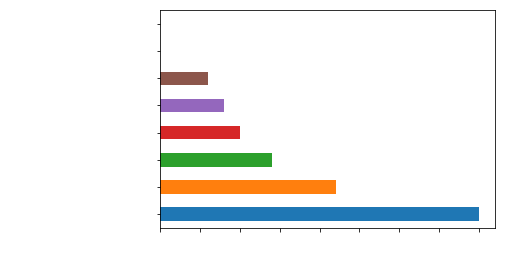

<Figure size 720x576 with 0 Axes>

In [66]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
label = plt.xlabel("Features")
label.set_color("white")
[i.set_color("white") for i in plt.gca().get_xticklabels()]
[i.set_color("white") for i in plt.gca().get_yticklabels()]
plt.figure(figsize=(10,8))
plt.show()



In [67]:
# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

### AdaBoost with Principle Component Analysis (PCA) 

In [68]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets

In [69]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

In [70]:
# Function to test PCA with a range of component values

for n in range(2,9):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(X_train, y_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    model.fit(X_train_pca, y_train)
    print("n="+str(n),model.score(X_test_pca, y_test),"")

n=2 0.5098901098901099 
n=3 0.5505494505494506 
n=4 0.5439560439560439 
n=5 0.5637362637362637 
n=6 0.578021978021978 
n=7 0.5747252747252747 
n=8 0.5835164835164836 


In [71]:
pca.explained_variance_

array([5.19002047e+02, 2.36556003e+01, 4.71420369e+00, 4.48522936e+00,
       2.93484675e+00, 8.18928261e-01, 1.37927307e-01, 8.97059199e-02])

In [72]:
pca.explained_variance_ratio_ 

array([9.33728156e-01, 4.25584064e-02, 8.48124732e-03, 8.06930332e-03,
       5.28003515e-03, 1.47332054e-03, 2.48142778e-04, 1.61388464e-04])

In [73]:
# import numpy as np
# i = np.identity(len(X_train[0]))
# i
# pd.DataFrame(pca.transform(i))
# These column names are equivalent to rows 0-9 in pca.transform above
# movies.columns

### AdaBoost Model with PCA and Scaled X_train and X_test data

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# X_scaler = MinMaxScaler(feature_range=[0, 1]).fit(X_train)
X_scaler = StandardScaler().fit(X_train)
# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [75]:
# Create adaboost classifier object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train_scaled, y_train)

In [76]:
# Function to test PCA with a range of component values

for n in range(2,9):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(X_train_scaled, y_train)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    model.fit(X_train_pca, y_train)
    print("n="+str(n),model.score(X_test_pca, y_test))

n=2 0.5285714285714286
n=3 0.5362637362637362
n=4 0.5813186813186814
n=5 0.5824175824175825
n=6 0.5769230769230769
n=7 0.5725274725274725
n=8 0.5648351648351648


In [77]:
pca.explained_variance_ratio_ 

array([0.28709395, 0.15699319, 0.13732044, 0.12200856, 0.1053253 ,
       0.09286037, 0.07923863, 0.01915955])

In [78]:
predicted = model.predict(X_test_scaled)

In [79]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[156, 246],
       [166, 342]], dtype=int64)

In [80]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
print(f"true negative: {tn:3d} false positive: {fp:3d}")
print(f"false negative: {fn:3d} true positive: {tp:3d}")

# This is also terrible.  

true negative: 156 false positive: 246
false negative: 166 true positive: 342


### Metrics for testing the final model

In [81]:
from sklearn.metrics import mean_squared_error, r2_score
# Use our model to predict a value
predicted = model.predict(X_test_pca)

# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
testing_score = model.score(X_test_pca,y_test)

print(f"mean squared error: {mse}")
print(f"r2: {r2}")
print(f"testing_score: {testing_score}")

mean squared error: 0.4351648351648352
r2: -0.7646021859207897
testing_score: 0.5648351648351648


In [82]:
# print score for tuned RF model
print(f"Accuracy: {metrics.accuracy_score(predicted,y_test)}")

Accuracy: 0.5648351648351648


In [89]:
# Create df from y-test:
actual_df = pd.DataFrame(y_test)
actual_df.head()
actual_df[0].value_counts()
# this is the number of successful (1) versus unsuccessful (0) declared by my model
# 1    508
# 0    402

1    508
0    402
Name: 0, dtype: int64

In [83]:
# Create df from predictions:
predicted_df = pd.DataFrame(predicted)
predicted_df.head()
predicted_df[0].value_counts()
# this is the number of successful (1) versus unsuccessful (0) declared by my model
# 1    572
# 0    338

1    572
0    338
Name: 0, dtype: int64

In [84]:
# format the predicted_df to calculate the percentage of total correct versus incorrect

# rename column 0 to Pred
predicted_df.rename({0 : "Pred"}, axis=1, inplace=True)
# Insert new column "Actual" with test data we are trying to predict (y_test)
predicted_df["Actual"] = y_test
# Create new column "Analysis" that substracts Pred from Actual (so anything that is a match is a zero,
# false positives become 1 and false negatives become -1)
predicted_df["Analysis"] = predicted_df["Actual"]-predicted_df["Pred"]
predicted_df.head()

,Pred,Actual,Analysis
0,1,0,-1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,1,1


In [85]:
# Map data in column Ananlysis to change 0 = correct and -1 or 1 = incorrect
predicted_df["Analysis"] = predicted_df["Analysis"].map({1:"Incorrect",-1:"Incorrect",0:"Correct"})
predicted_df.head()

,Pred,Actual,Analysis
0,1,0,Incorrect
1,0,0,Correct
2,0,0,Correct
3,0,0,Correct
4,0,1,Incorrect


In [86]:
# count incorrect versus correct in predicted_df
predicted_df["Analysis"].value_counts()

# Correct      514
# Incorrect    396

Correct      514
Incorrect    396
Name: Analysis, dtype: int64

## Predict "Once Upon A Time In Hollywood"

In [87]:
new_movie1 = [[159, 4, 3.533546, 4.0, 1, 1, 9, 14.447285]]
predicted_class_movie1 = model.predict(new_movie1)
print(f"Once Upon a Time in Hollywood has a predicted class of {predicted_class_movie1} according to the current AdaBoost model.")

# Predicted the movie as a failure (0)

Once Upon a Time in Hollywood has a predicted class of [0] according to the current QDA model.
